In [25]:
# Importation des bibliothèques de base
import pandas as pd
import numpy as np
import pickle
import os

# Bibliothèques de machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
import xgboost as xgb
from sklearn.ensemble import IsolationForest

# Bibliothèques de prétraitement
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Bibliothèques pour l'optimisation des hyperparamètres
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from hyperopt.pyll.base import scope

# Bibliothèques de visualisation
import matplotlib.pyplot as plt
import seaborn as sns
SEED=42
# Configuration de style pour les graphiques
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
%matplotlib inline


In [7]:
# Chemin vers le fichier CSV prétraité
data_path = 'data/creditcard.csv'

# Chargement des données dans un DataFrame pandas
data = pd.read_csv(data_path)

# Affichage des premières lignes du dataset
data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
# Séparation des features (X) et de la variable cible (y)
X = data.drop('Class', axis=1)
y = data['Class']


In [10]:
# Initialisation du scaler
scaler = StandardScaler()

# Entraînement du scaler sur les données d'entraînement
X_scaled = scaler.fit_transform(X)

# Sauvegarde du scaler
scaler_path = 'models/scaler.pkl'

# Créer le dossier 'models' s'il n'existe pas
os.makedirs(os.path.dirname(scaler_path), exist_ok=True)

with open(scaler_path, 'wb') as file:
    pickle.dump(scaler, file)

print(f"Scaler sauvegardé dans '{scaler_path}'")


Scaler sauvegardé dans 'models/scaler.pkl'


In [11]:
# Séparation en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [12]:
def aucpr_metric(y_true, y_scores):
    return average_precision_score(y_true, y_scores)


 ## Définition des Espaces de Recherche pour Hyperopt

In [13]:
space_xgb = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 50)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 10, 1)),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.3)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(0.0001), np.log(10)),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(0.0001), np.log(10))
}


In [16]:
space_iforest = {
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 300, 10)),
    'max_samples': hp.uniform('max_samples', 0.5, 1.0),
    'max_features': hp.uniform('max_features', 0.5, 1.0),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'behaviour': hp.choice('behaviour', ['new', 'deprecated'])
}


## Définition des Fonctions Objectifs pour Hyperopt

In [26]:
def objective_xgb(params):
    # Convertir les paramètres
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    
    # Initialiser le modèle
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        **params,
        random_state=SEED
    )
    
    # Entraîner le modèle
    model.fit(X_train, y_train)
    
    # Prédictions sur l'ensemble de validation
    y_pred_proba = model.predict_proba(X_val)[:,1]
    
    # Calculer la métrique AUC-PR
    aucpr = aucpr_metric(y_val, y_pred_proba)
    
    return {'loss': -aucpr, 'status': STATUS_OK}


In [20]:
# Calcul de la contamination basée sur les données d'entraînement
contamination = y.sum()/len(y)
print(f"Contamination estimée: {contamination:.6f} ({contamination*100:.4f}%)")


Contamination estimée: 0.001727 (0.1727%)


In [32]:
def objective_iforest(params):
    # Utiliser la contamination calculée précédemment
    params['contamination'] = contamination
    
    # Initialiser le modèle
    model = IsolationForest(
        n_estimators=int(params['n_estimators']),
        max_samples=params['max_samples'],
        contamination=params['contamination'],  # Utiliser la contamination calculée
        max_features=params['max_features'],
        
        random_state=SEED
    )
    
    # Entraîner le modèle
    model.fit(X_train)
    
    # Prédictions (1: normal, -1: anomalie)
    y_pred = model.predict(X_val)
    
    # Conversion des prédictions en format binaire
    y_pred_binary = np.where(y_pred == -1, 1, 0)  # 1: Anomalie (Fraude), 0: Normal
    
    # Calculer la métrique AUC-PR
    aucpr = average_precision_score(y_val, y_pred_binary)
    
    return {'loss': -aucpr, 'status': STATUS_OK}


In [ ]:
# Initialiser les essais
trials_xgb = Trials()

# Exécuter l'optimisation
best_xgb = fmin(
    fn=objective_xgb,
    space=space_xgb,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials_xgb,
    rstate=np.random.default_rng(SEED)
)

print("Meilleurs Hyperparamètres pour XGBoost:")
print(best_xgb)


In [35]:
# Initialiser les essais
trials_iforest = Trials()

# Exécuter l'optimisation
best_iforest = fmin(
    fn=objective_iforest,
    space=space_iforest,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials_iforest,
    rstate=np.random.default_rng(SEED)
)

print("Meilleurs Hyperparamètres pour Isolation Forest:")
print(best_iforest)


100%|██████████| 50/50 [21:36<00:00, 25.94s/trial, best loss: -0.14005987981611392]
Meilleurs Hyperparamètres pour Isolation Forest:
{'behaviour': 1, 'bootstrap': 1, 'max_features': 0.8327683247861657, 'max_samples': 0.8543503833816739, 'n_estimators': 190.0}


In [49]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(f'Matrice de Confusion - {model_name}')
    plt.xlabel('Prédictions')
    plt.ylabel('TRUE')
    plt.xticks([0.5,1.5], ['Non-Fraude', 'Fraude'])
    plt.yticks([0.5,1.5], ['Non-Fraude', 'Fraude'], rotation=0)
    plt.show()


In [38]:
# Convertir les paramètres optimisés
best_xgb['n_estimators'] = int(best_xgb['n_estimators'])
best_xgb['max_depth'] = int(best_xgb['max_depth'])

# Initialiser le modèle avec les meilleurs hyperparamètres
model_xgb = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    **best_xgb,
    random_state=42
)

# Entraîner le modèle sur l'ensemble d'entraînement
model_xgb.fit(X_train, y_train)

# Prédictions sur l'ensemble de validation
y_pred_xgb = model_xgb.predict(X_val)
y_proba_xgb = model_xgb.predict_proba(X_val)[:,1]

# Évaluation
print("=== XGBoost Optimisé ===")
print("Classification Report:")
print(classification_report(y_val, y_pred_xgb))
print(f"AUC-PR: {average_precision_score(y_val, y_proba_xgb):.4f}")


c:\Users\esper\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:44:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


=== XGBoost Optimisé ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.81      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962

AUC-PR: 0.8822


In [42]:
# Interpréter le comportement
# Dans Hyperopt, 'behaviour' a été encodé comme 0: 'new', 1: 'deprecated'
#best_iforest['behaviour'] = 'new' if best_iforest['behaviour'] == 0 else 'deprecated'

# Initialiser le modèle avec les meilleurs hyperparamètres
model_iforest = IsolationForest(
    n_estimators=int(best_iforest['n_estimators']),
    max_samples=best_iforest['max_samples'],
    contamination=contamination,  # Utiliser la contamination calculée
    max_features=best_iforest['max_features'],
    
   
    random_state=42
)

# Entraîner le modèle sur l'ensemble d'entraînement
model_iforest.fit(X_train)

# Prédictions sur l'ensemble de validation
y_pred_iforest = model_iforest.predict(X_val)
y_scores_iforest = model_iforest.decision_function(X_val)  # Plus le score est élevé, plus c'est une anomalie

# Conversion des prédictions en format binaire
y_pred_iforest_binary = np.where(y_pred_iforest == -1, 1, 0)  # 1: Anomalie (Fraude), 0: Normal

# Évaluation
print("=== Isolation Forest Optimisé ===")
print("Classification Report:")
print(classification_report(y_val, y_pred_iforest_binary))
print(f"AUC-PR: {average_precision_score(y_val, y_pred_iforest_binary):.4f}")


=== Isolation Forest Optimisé ===
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.36      0.39      0.37        98

    accuracy                           1.00     56962
   macro avg       0.68      0.69      0.69     56962
weighted avg       1.00      1.00      1.00     56962

AUC-PR: 0.1401


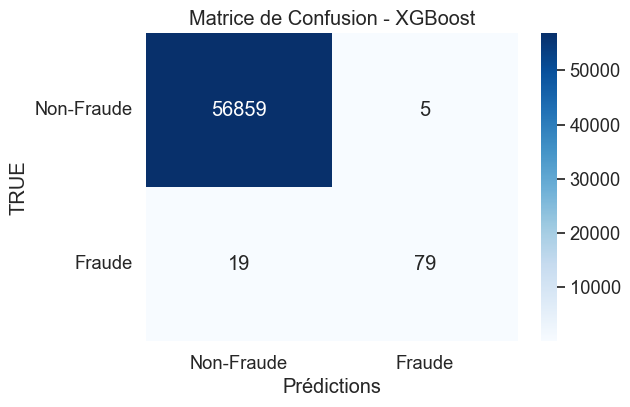

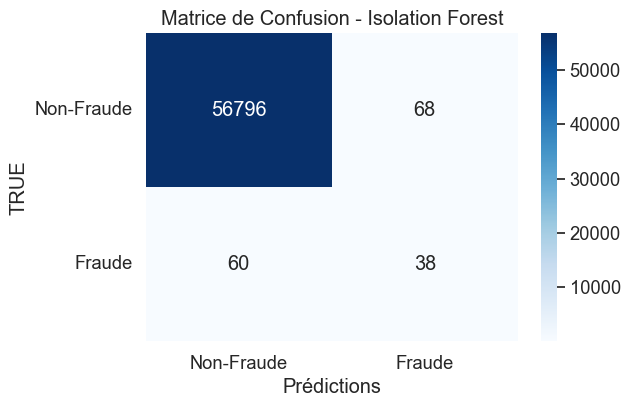

In [50]:
# Matrice de confusion pour XGBoost
plot_confusion_matrix(y_val, y_pred_xgb, 'XGBoost')

# Matrice de confusion pour Isolation Forest
plot_confusion_matrix(y_val, y_pred_iforest_binary, 'Isolation Forest')


In [51]:
# Entraîner le meilleur modèle sur l'ensemble des données
best_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    **best_xgb,
    random_state=42
)

best_model.fit(X, y)

# Sauvegarder le modèle entraîné
model_output_path = 'models/xgb_model.pkl'

# Créer le dossier 'models' s'il n'existe pas
os.makedirs(os.path.dirname(model_output_path), exist_ok=True)

with open(model_output_path, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Modèle XGBoost optimisé sauvegardé dans '{model_output_path}'")


c:\Users\esper\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:51:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Modèle XGBoost optimisé sauvegardé dans 'models/xgb_model.pkl'
